In [1]:
from scipy import stats
import pandas as pd
import numpy as np
from glob import glob
import os
from statsmodels.stats.multitest import multipletests

from itertools import combinations
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import plot_init as pu

In [2]:
def calculate_spearmanr(arr1, arr2):
        """Calculate spearman rank correlation"""
        temp_df = pd.DataFrame()
        temp_df['arr1'] = arr1
        temp_df['arr2'] = arr2
        temp_df = temp_df.dropna()
        
        arr1 = temp_df['arr1']
        arr2 = temp_df['arr2']
        
        corr, pval = stats.spearmanr(arr1, arr2)
        return corr, pval, corr**2 # effect size   
    
def calculate_chi(arr1, arr2):
        """Calculate Chi-square test of independence"""
        temp_df = pd.DataFrame()
        temp_df['arr1'] = arr1
        temp_df['arr2'] = arr2
        temp_df = temp_df.dropna()
        
        arr1 = temp_df['arr1']
        arr2 = temp_df['arr2']
        
        row_count = arr1.nunique()
        col_count = arr2.nunique()


        contingency = pd.crosstab(arr1, arr2)
        n = contingency.sum().sum()
        
        # Chi-square test of independence.
        corr, pval, dof, expected = stats.chi2_contingency(
            contingency, correction=False, lambda_=None)
        
        # returns chi2, p_uncorrected, dof, expected, num_rows, num_cols, n
        return corr, pval, dof, expected, row_count, col_count, n
    
def bergsma_corrected_cramers_v2(chi2, row_count, col_count, n):
    """Calculate cramers_v2_corrected"""
    
    phi2 = chi2/n
    phi2_corrected = phi2 - (1/(n-1))*(row_count-1)*(col_count-1)
    phi2_corrected_nonneg = max(0, phi2_corrected)

    row_count_corrected = row_count - (1/(n-1))*(row_count-1)**2
    col_count_corrected = col_count - (1/(n-1))*(col_count-1)**2

    cramers_v2_corrected = phi2_corrected_nonneg/min(row_count_corrected-1, col_count_corrected-1)

    return cramers_v2_corrected # effect size

def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """
    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test
    Arguments:
    ---------------
    groups: sequence, pd.Series
        arrays corresponding to k mutually independent samples from
        continuous populations
        For pd.Series inputs,  index is group (category) and values are arrays
        of numerical var values belonging to that group.
    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.
    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)
    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)
    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic
    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal
    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison
    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.
    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha
    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.
    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])

    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)

    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')


    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()


    # the Kruskal-Wallis H-statistic
    H = ((12. / (N * (N + 1.))) 
         * ((R ** 2.) / n).sum() - 3 * (N + 1))

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.distributions.chi2.sf(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------
    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=float)
    p_uncorrected = np.empty(ncomp, dtype=float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):

        # standardized score
        Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
               np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method)


    return H, p_omnibus, Z_pairs, p_corrected, reject

def calculate_annova(cat_arr, num_arr):
    """Calculate Kruskal-Wallis anova and Dunn’s post hoc test"""
    temp_df = pd.DataFrame()
    temp_df['cat'] = cat_arr
    temp_df['num'] = num_arr
    temp_df = temp_df.dropna()
    
    alpha = 0.05
    N_samples = df.shape[0]
    
    # initialize input series, index : group, values : arr of 'num' vals per group
    input_ = temp_df.groupby('cat')['num'].apply(list)

    H, p_omnibus, Z_pairs, p_corrected, reject = kw_dunn(input_, method='bonf') 

    max_index = np.argmax(Z_pairs)
    Z_max = Z_pairs[max_index]

    p_corrected_max = (p_corrected[max_index])
    reject_max = (reject[max_index])

    #if Kruskal-Wallis analysis of variance gives a significant result, use Dunn’s post hoc test
    if p_omnibus >= alpha:
        #meaning P-value > α: The differences between the medians are not statistically significant
        pval = p_omnibus          # kw
    else: 
        pval = p_corrected_max    #dunns

    corr = Z_max / (N_samples)**0.5
    Z2_max = (Z_max**2) / N_samples


    return corr, pval, Z2_max # effect size

## Inspect Data

In [3]:
# read data: mean
agg = 'mean'
lookback_window = 60
source_date = '2022-06-01'

glob_path = f'../datasets/per-vehicle-moving-average/{agg}-window-{lookback_window}-{source_date}/*.csv'
filepaths = glob(glob_path)

In [4]:
def correct_service_rd_kphlimit(temp_df):
    temp_df.loc[temp_df['speed_limit_kph'] == 36.7, 'speed_limit_kph'] = 20
    return temp_df

In [5]:
# get dtypes
dtypes_dict = pd.read_csv(filepaths[0]).dtypes.to_dict()

# set low_memory=False to ensure no mixed types
full_df = pd.concat([pd.read_csv(path, dtype=dtypes_dict) for path in filepaths])
full_df = correct_service_rd_kphlimit(full_df)

full_df.info()
display(full_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33817601 entries, 0 to 132806
Data columns (total 43 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   datetime               object 
 1   altitude               int64  
 2   angle                  int64  
 3   instant_speed          int64  
 4   accel                  float64
 5   ai1                    int64  
 6   ai2                    int64  
 7   ai3                    int64  
 8   ai4                    int64  
 9   alarm_code             int64  
 10  bats                   int64  
 11  decel                  float64
 12  di1                    int64  
 13  di2                    int64  
 14  di3                    int64  
 15  di4                    int64  
 16  di5                    int64  
 17  do1                    int64  
 18  do2                    int64  
 19  do3                    int64  
 20  do4                    int64  
 21  gpslev                 int64  
 22  hdop              

datetime  altitude  angle  instant_speed  accel  ai1  \
0  2021-02-19 09:42:48+08:00        79    127              0    0.0    0   
1  2021-02-19 09:43:19+08:00        79     93              0    0.0    0   
2  2021-02-19 09:43:49+08:00        79    189              0    0.0    0   
3  2021-02-19 09:44:19+08:00        79    115              0    0.0    0   
4  2021-02-19 09:44:47+08:00        79     13              0    0.0    0   

    ai2  ai3  ai4  alarm_code  ...  hour  dayofweek  month  elevation  \
0  1023  307  628           0  ...     9          4      2         58   
1  1023  303  628           0  ...     9          4      2         58   
2  1023  305  629           0  ...     9          4      2         58   
3  1023  306  629           0  ...     9          4      2         58   
4  1023  300  629          33  ...     9          4      2         58   

   pix_business_4x4  pix_residential_4x4  pix_industrial_4x4  \
0               222                 1111                  14   
1               222                 1111                  14   
2               222                 1111                  14   
3               222                 1111                  14   
4               222                 1111                  14   

   pix_institutional_4x4  num_periods  agg_speed  
0                    503            1        0.0  
1                    503            2        0.0  
2                    503            2        0.0  
3                    503            2        0.0  
4                    503            3        0.0  

[5 rows x 43 columns]

In [6]:
# quick eda on some cols
def filter_data(df, thresh):
    if thresh:
        df = df.loc[df['num_periods'] >= thresh]
        return df
    else:
        return df

In [7]:
# # FILTERED
# thresh = 12
# original_size = full_df.shape[0]
# full_df = filter_data(full_df, thresh=thresh)
# new_size = full_df.shape[0]

# above_thresh_percentage = (new_size / original_size) * 100
# print(f"Percentage of samples with period equal to or over {thresh}: ", above_thresh_percentage)

In [8]:
# use filtered
test_size = 0.20 # 20% of data set used for evaluation, 80% as train
tuning_size = 0.20 # 20% of the training set is used for tuning


retrain, test = train_test_split(full_df, test_size=test_size, random_state=11)
_, tune = train_test_split(retrain, test_size=tuning_size, random_state=11)

# run_date = str(datetime.now().date()) # now date
# print(run_date)

In [9]:
label_map = {
    'hour' : 'Hour',
    'month' : 'Month',
    'dayofweek' : 'Day of week',
    'pix_residential_4x4' : 'Nearby Residential',
    'pix_institutional_4x4' : 'Nearby Institutional',
    'pix_industrial_4x4' : 'Nearby Industrial',
    'pix_business_4x4' : 'Nearby Commercial',
    'number_of_lanes' : 'Number of Lanes',
    'road_segment_length' : 'Road segment length',
    'speed_limit_kph' : 'Speed Limit',
    'decel' : 'Deceleration',
    'distance_to_road' : 'Vehicle distance\nto road center',
    'accel' : 'Acceleration',
    'elevation': 'Elevation (m)',
    'agg_speed' : 'Aggregated speed',
}

categorical_cols = ['hour', 'dayofweek', 'month']
numerical_cols = ['pix_residential_4x4', 'pix_business_4x4', 'pix_institutional_4x4', 'pix_industrial_4x4', 
                  'number_of_lanes', 'road_segment_length', 'speed_limit_kph', 'elevation', 'accel', 'decel', 
                  'distance_to_road', 'agg_speed']

usecols = categorical_cols + numerical_cols
df = full_df
df = df[usecols]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33817601 entries, 0 to 132806
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   hour                   int64  
 1   dayofweek              int64  
 2   month                  int64  
 3   pix_residential_4x4    int64  
 4   pix_business_4x4       int64  
 5   pix_institutional_4x4  int64  
 6   pix_industrial_4x4     int64  
 7   number_of_lanes        float64
 8   road_segment_length    float64
 9   speed_limit_kph        float64
 10  elevation              int64  
 11  accel                  float64
 12  decel                  float64
 13  distance_to_road       float64
 14  agg_speed              float64
dtypes: float64(7), int64(8)
memory usage: 4.0 GB


In [11]:
df.isnull().any()

hour                     False
dayofweek                False
month                    False
pix_residential_4x4      False
pix_business_4x4         False
pix_institutional_4x4    False
pix_industrial_4x4       False
number_of_lanes           True
road_segment_length      False
speed_limit_kph          False
elevation                False
accel                     True
decel                     True
distance_to_road         False
agg_speed                False
dtype: bool

In [12]:
df.describe()

hour     dayofweek         month  pix_residential_4x4  \
count  3.381760e+07  3.381760e+07  3.381760e+07         3.381760e+07   
mean   1.192471e+01  2.842198e+00  5.949321e+00         7.667400e+02   
std    4.119109e+00  2.015307e+00  2.524247e+00         5.958744e+02   
min    0.000000e+00  0.000000e+00  2.000000e+00         0.000000e+00   
25%    9.000000e+00  1.000000e+00  4.000000e+00         3.490000e+02   
50%    1.200000e+01  3.000000e+00  6.000000e+00         6.160000e+02   
75%    1.500000e+01  4.000000e+00  8.000000e+00         1.014000e+03   
max    2.300000e+01  6.000000e+00  1.100000e+01         2.796000e+03   

       pix_business_4x4  pix_institutional_4x4  pix_industrial_4x4  \
count      3.381760e+07           3.381760e+07        3.381760e+07   
mean       5.132706e+02           8.166392e+01        7.113203e+01   
std        6.891247e+02           1.478984e+02        1.416313e+02   
min        0.000000e+00           0.000000e+00        0.000000e+00   
25%        0.000000e+00           0.000000e+00        0.000000e+00   
50%        2.520000e+02           8.000000e+00        0.000000e+00   
75%        7.470000e+02           8.700000e+01        8.200000e+01   
max        3.299000e+03           9.640000e+02        2.018000e+03   

       number_of_lanes  road_segment_length  speed_limit_kph     elevation  \
count     3.294062e+07         3.381760e+07     3.381760e+07  3.381760e+07   
mean      2.015445e+00         2.185728e+02     4.053989e+01  5.841174e+01   
std       1.185719e+00         2.763423e+02     1.916828e+01  5.854526e+00   
min       1.000000e+00         1.536000e+00     2.000000e+01  3.600000e+01   
25%       1.000000e+00         8.037400e+01     2.000000e+01  5.500000e+01   
50%       2.000000e+00         1.348170e+02     3.000000e+01  5.900000e+01   
75%       2.000000e+00         2.346220e+02     6.000000e+01  6.200000e+01   
max       4.000000e+00         3.770401e+03     8.000000e+01  2.110000e+02   

              accel         decel  distance_to_road     agg_speed  
count  3.381751e+07  3.381751e+07      3.381760e+07  3.381760e+07  
mean   1.274855e+00  1.450593e+00      6.698894e+00  1.833502e+01  
std    1.820796e+00  1.986571e+00      2.922462e+01  1.131665e+01  
min    0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00      1.632663e-01  1.050000e+01  
50%    1.000000e+00  1.000000e+00      3.116516e-01  1.785714e+01  
75%    2.000000e+00  2.000000e+00      1.540398e+00  2.640000e+01  
max    7.600000e+01  9.900000e+01      2.532944e+03  8.900000e+01

## Inspect Distributions

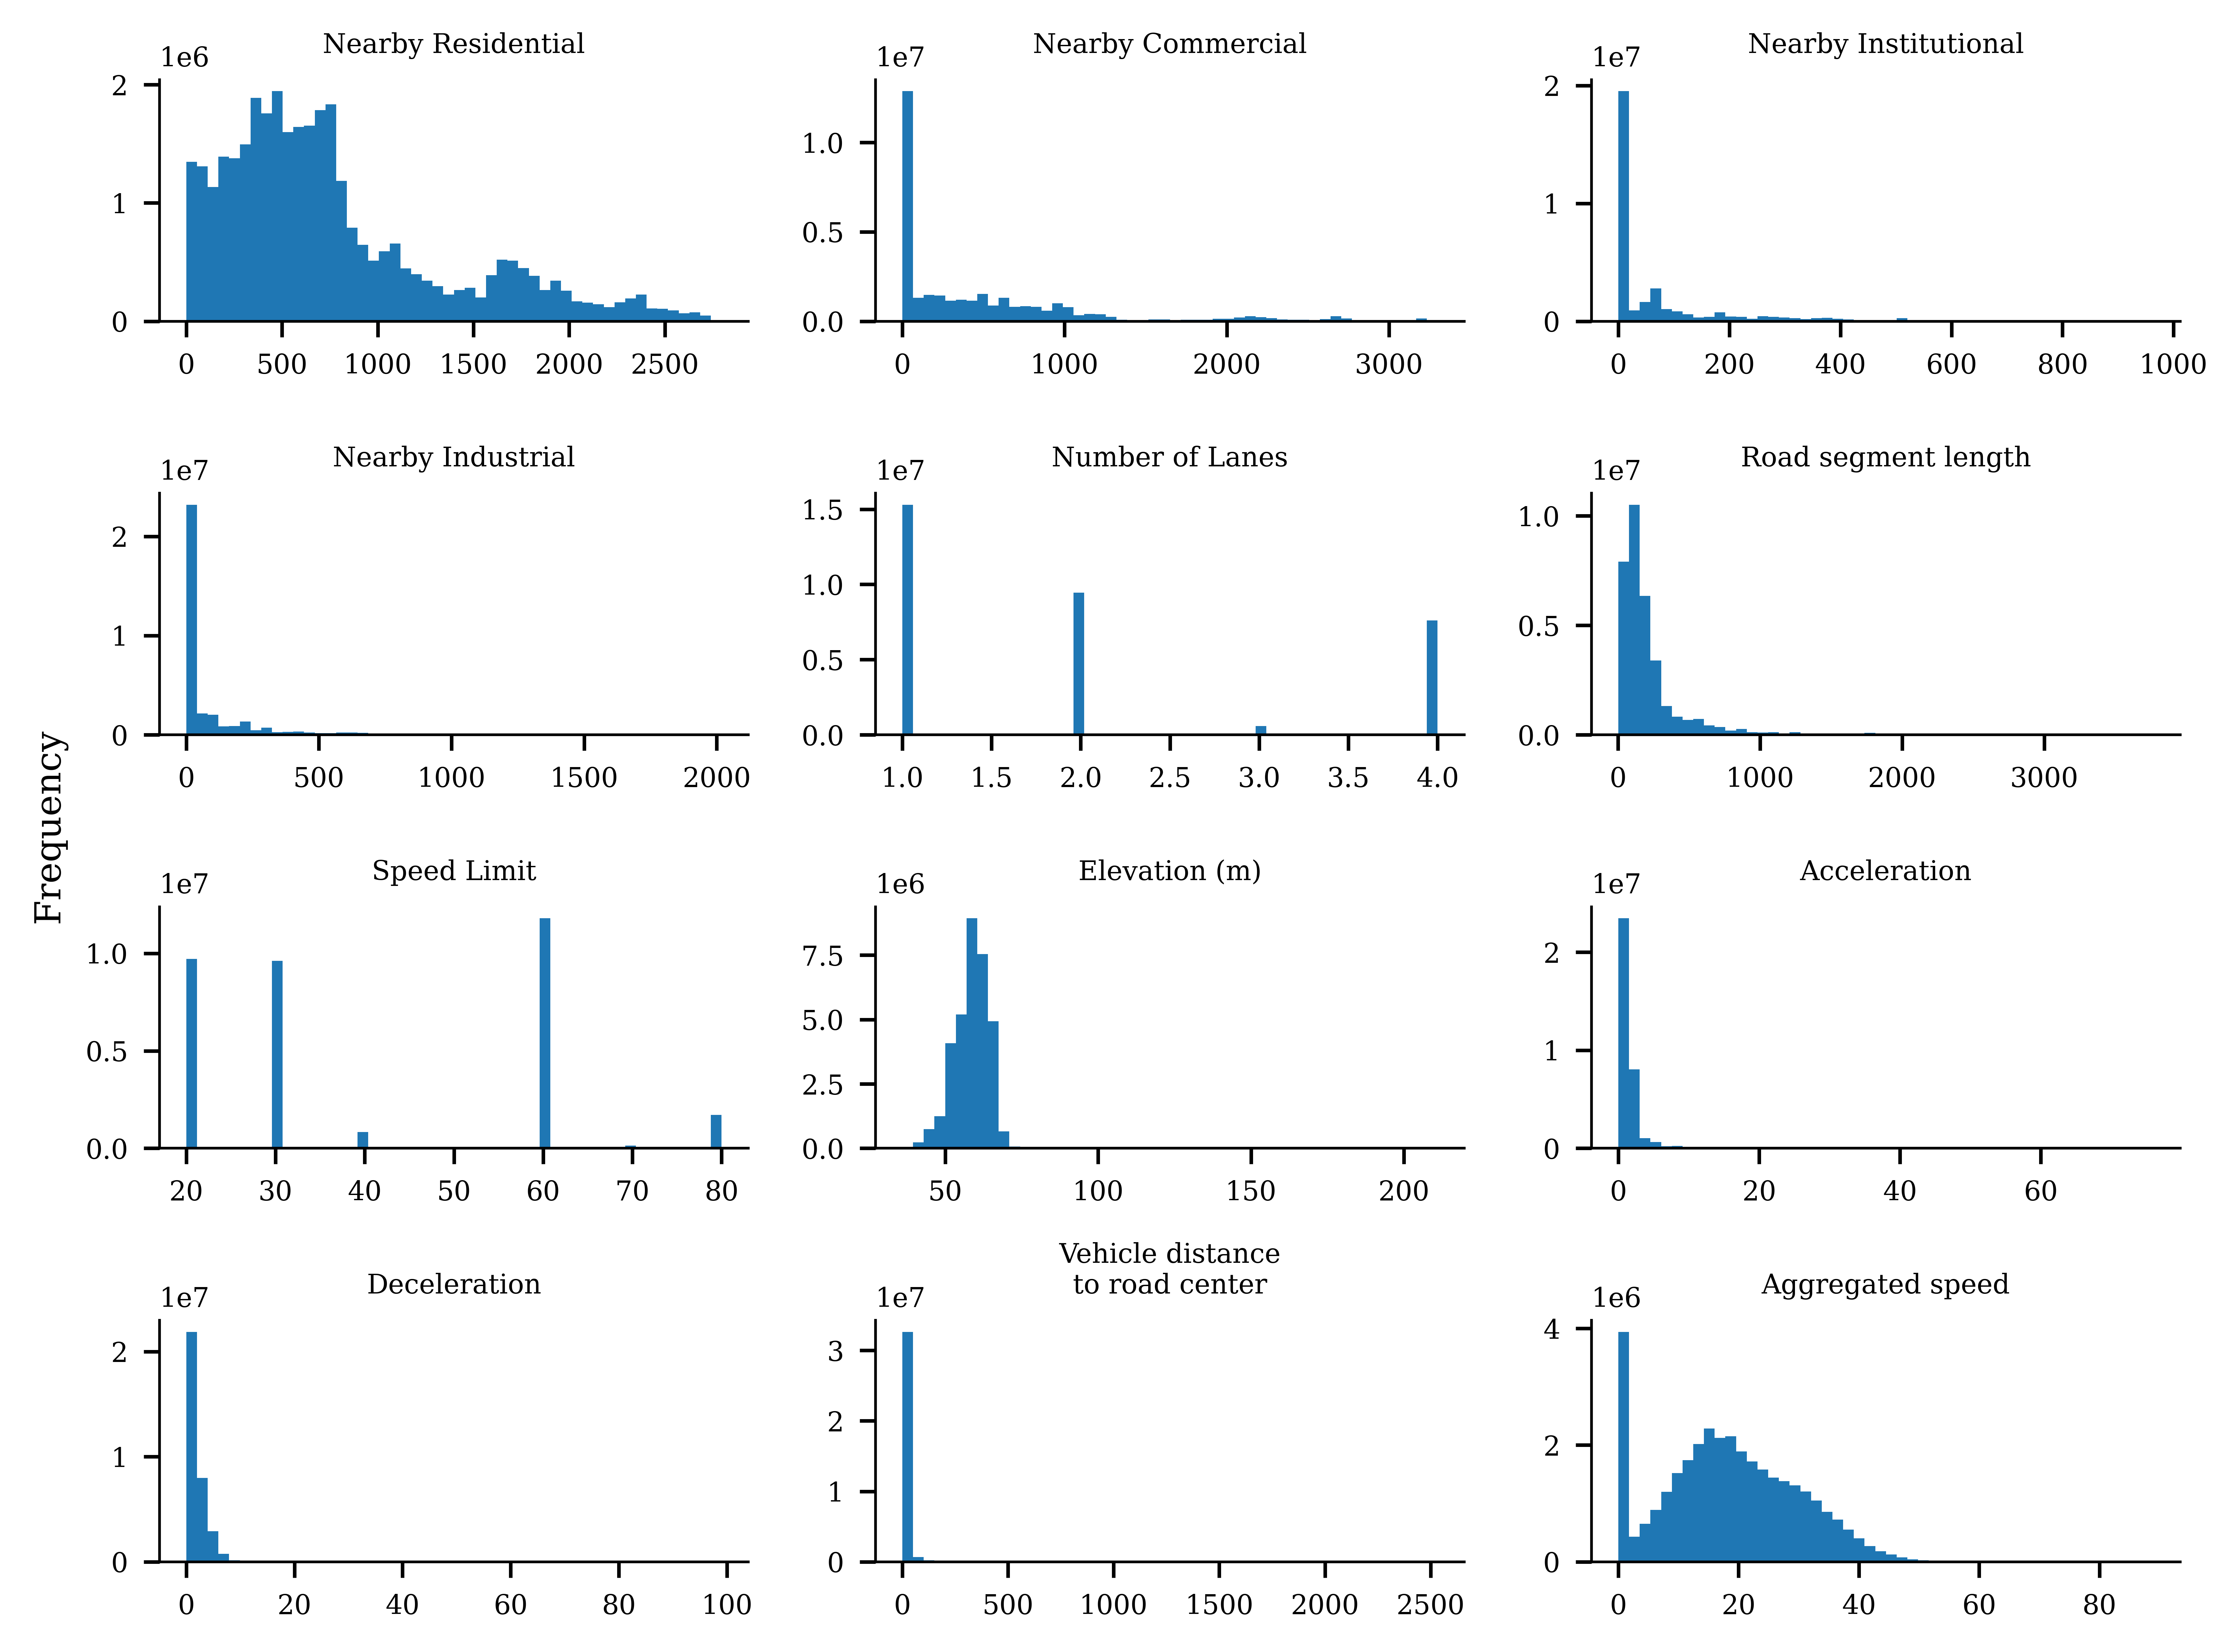

In [13]:
import matplotlib.pyplot as plt

# _, axes = plt.subplots(4, 3, figsize=(20, 15))
fig, axes = plt.subplots(4, 3, figsize=pu.figsizes['double'])

flat_axes = axes.flatten()
for index, col in enumerate(numerical_cols):
    df[col].plot.hist(bins=50, ax=flat_axes[index])
    flat_axes[index].set_title(label_map[col], fontsize=pu.tiny)
    flat_axes[index].spines[['top', 'right']].set_visible(False)
    flat_axes[index].tick_params(axis='both', labelsize=pu.tiny)
    ylabel = flat_axes[index].get_ylabel()
    flat_axes[index].set_ylabel('')
    
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
plt.tight_layout(pad=1.0)
plt.show()

## Feature Engineering

In [14]:
# feature engineering (removing outliers, impute on nulls)
df = df[df.distance_to_road <= 100] # meters away from an edge linestring

## these were already filtered prior
# df = df[df.accel <= 20]
# df = df[df.decel <= 20] 
# df = df[df.vehicle_speed <= 60] 
# df = df[df.altitude <= 5000] 

df = df.dropna(subset=['accel', 'decel'])
df['number_of_lanes'] = df['number_of_lanes'].fillna(value=1.0)

### New distributions

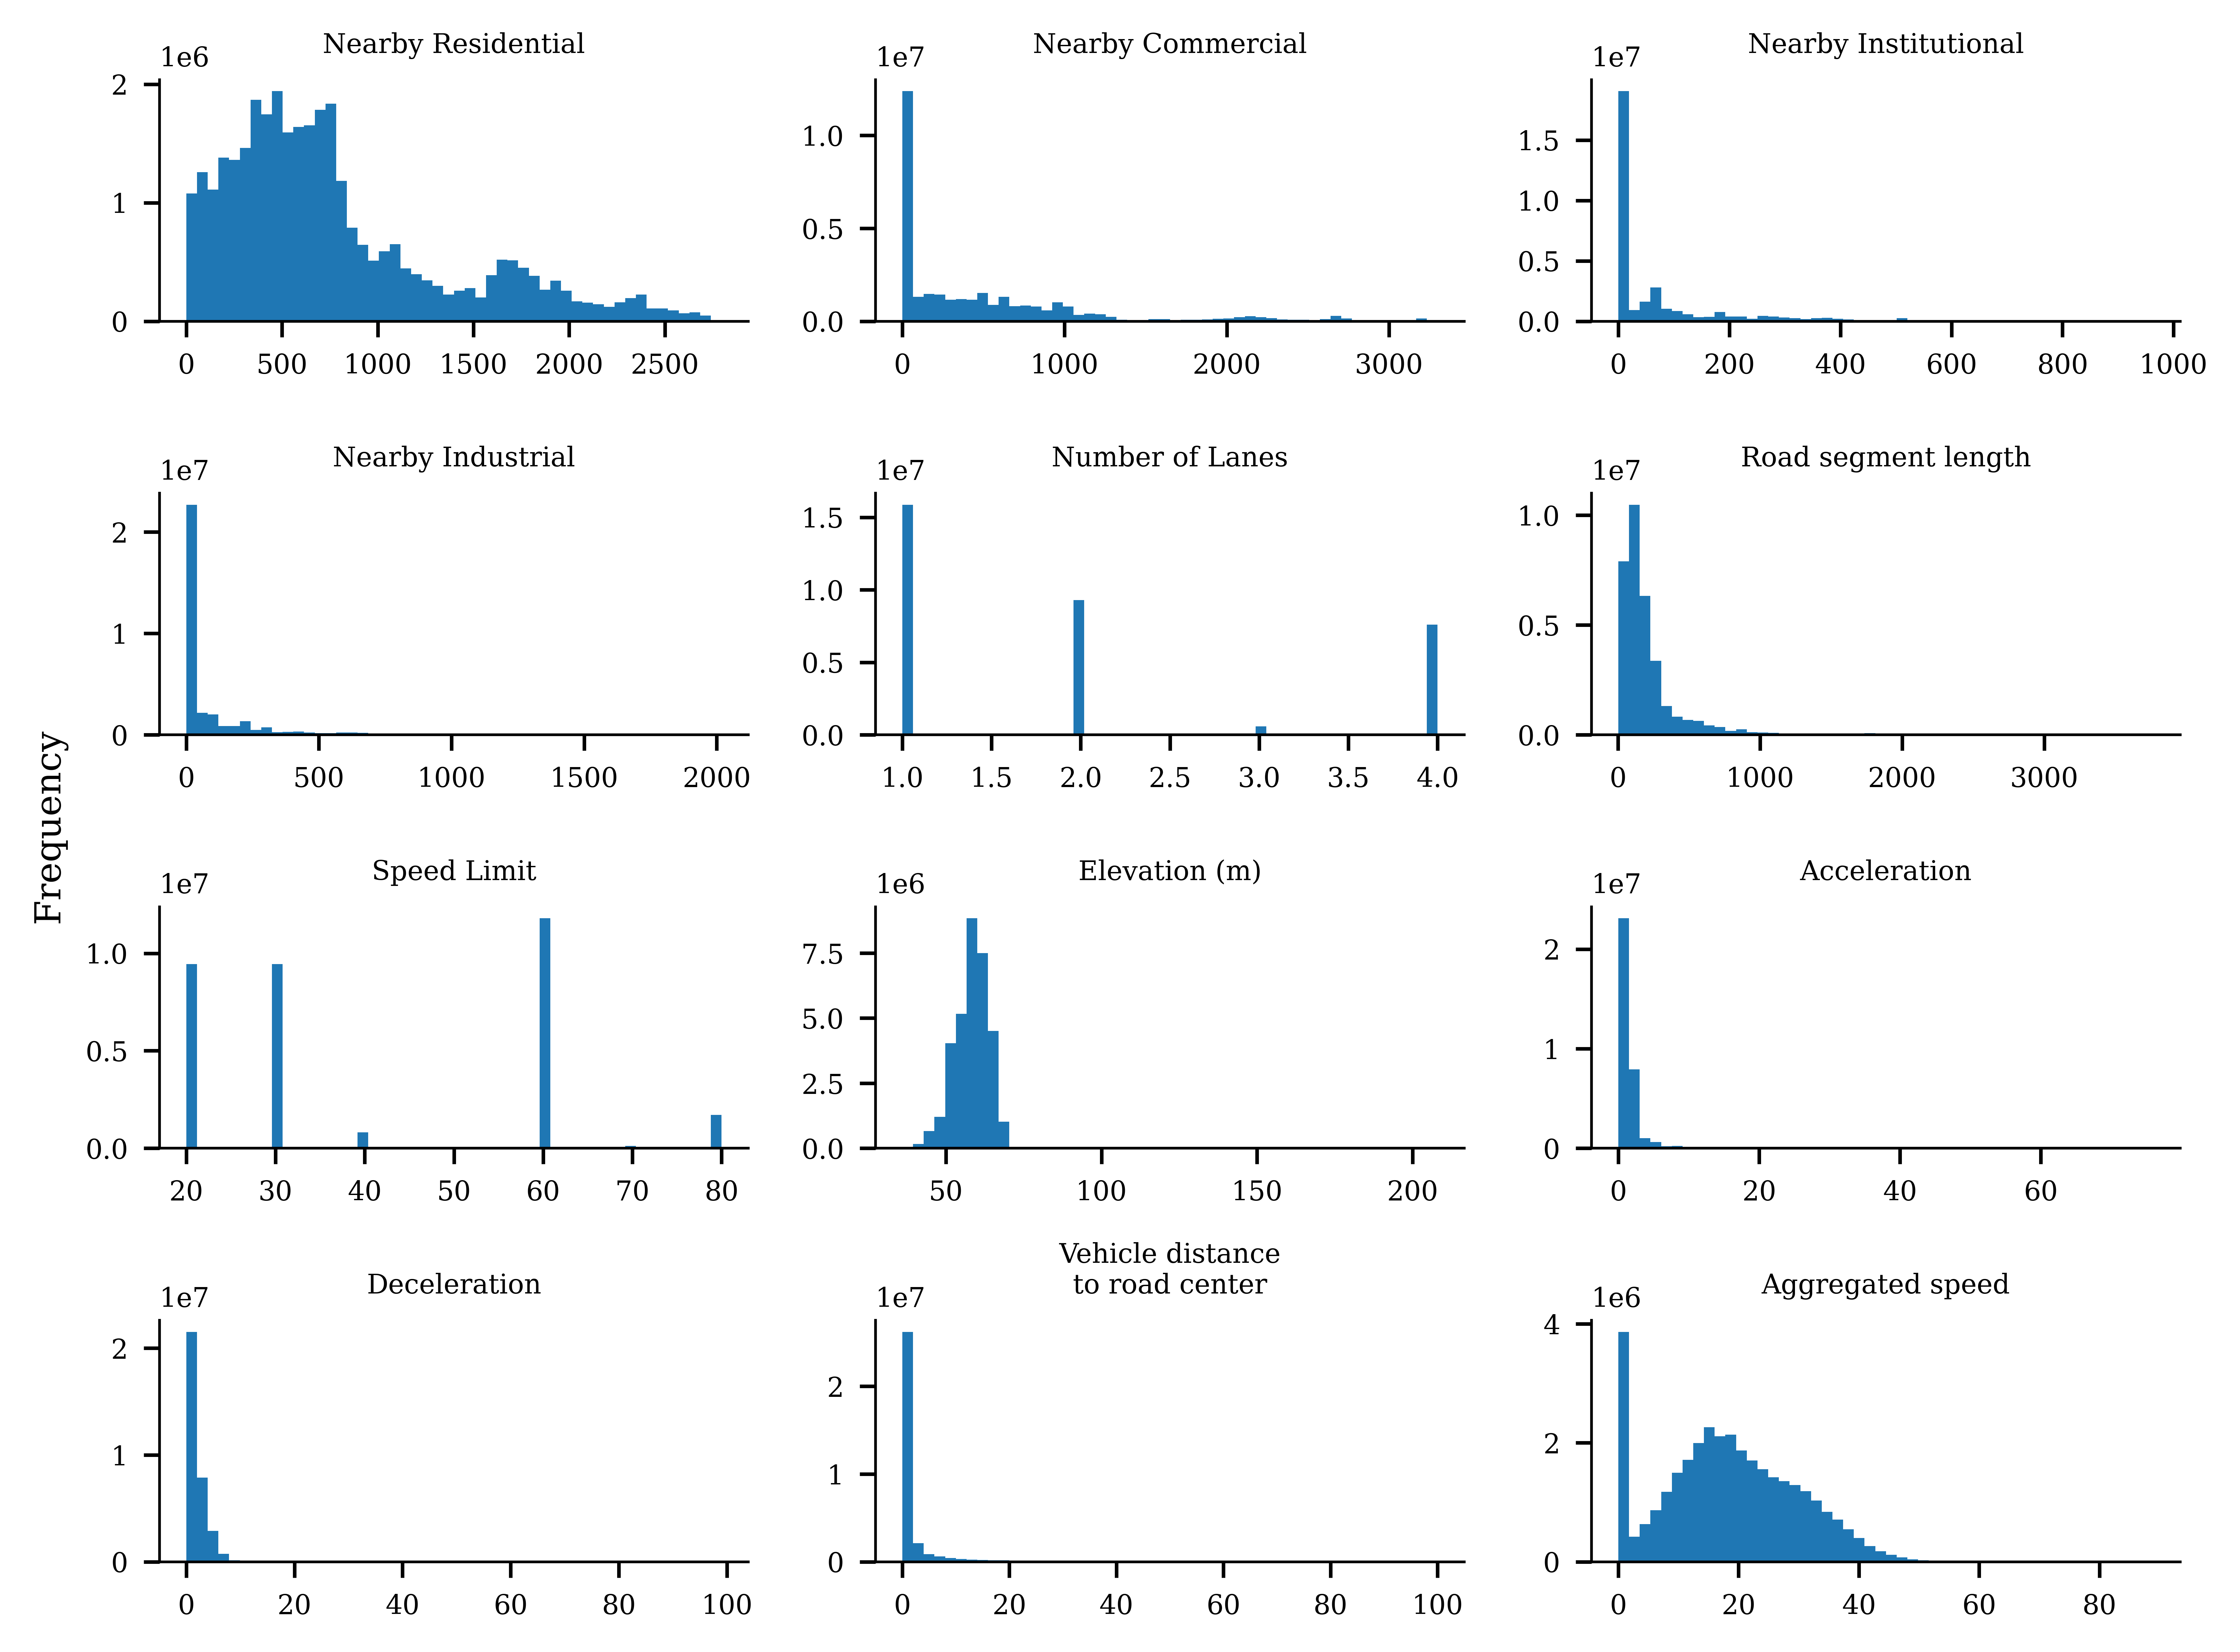

In [15]:
import matplotlib.pyplot as plt

# _, axes = plt.subplots(4, 3, figsize=(20, 15))
fig, axes = plt.subplots(4, 3, figsize=pu.figsizes['double'])
flat_axes = axes.flatten()
for index, col in enumerate(numerical_cols):
    df[col].plot.hist(bins=50, ax=flat_axes[index])
    flat_axes[index].set_title(label_map[col], fontsize=pu.tiny)
    flat_axes[index].spines[['top', 'right']].set_visible(False)
    flat_axes[index].tick_params(axis='both', labelsize=pu.tiny)
    ylabel = flat_axes[index].get_ylabel()
    flat_axes[index].set_ylabel('')
    
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
plt.tight_layout(pad=1.0)

plt.savefig('../figures/feature_distributions_FULL.pdf', bbox_inches='tight')
# plt.savefig('../figures/feature_distributions_FILTERED.pdf', bbox_inches='tight')
plt.show()

## Calculate Effect Sizes, Correlations, and p-values

In [16]:
features = list(sorted(set(df.columns) - set(['agg_speed'])))
feature_combinations = list(combinations(features, 2))

effect_size_df = pd.DataFrame(index=usecols, columns=usecols)
corr_df = pd.DataFrame(index=usecols, columns=usecols)
pval_df = pd.DataFrame(index=usecols, columns=usecols)

for feat1, feat2 in tqdm(feature_combinations):
    if (feat1 in categorical_cols) & (feat2 in categorical_cols): # chi2-cramersv
        arr1, arr2 = df[feat1], df[feat2]
        corr, pval, dof, expected, row_count, col_count, n = calculate_chi(arr1, arr2)
        
        # corrected cramersv, corr is chi2
        effect_size = bergsma_corrected_cramers_v2(corr, row_count, col_count, n)
    
    elif (feat1 in numerical_cols) & (feat2 in numerical_cols): # spearmanr
        arr1, arr2 = df[feat1], df[feat2]
        corr, pval, effect_size = calculate_spearmanr(arr1, arr2)
    
    else:
        if feat1 in categorical_cols: # feat1 is cat
            # Z2_max : effect_size
            cat_arr = df[feat1]
            num_arr = df[feat2]
        else: # feat2 is cat
            cat_arr = df[feat2]
            num_arr = df[feat1]
            
        corr, pval, effect_size = calculate_annova(cat_arr, num_arr)
    
    effect_size_df.loc[feat1, feat2] = effect_size
    corr_df.loc[feat1, feat2] = corr
    pval_df.loc[feat1, feat2] = pval

100%|██████████| 91/91 [20:27<00:00, 13.49s/it]


In [17]:
effect_size_df

hour dayofweek     month pix_residential_4x4  \
hour                        NaN       NaN  0.000529            0.000622   
dayofweek              0.000675       NaN  0.004359            0.000464   
month                       NaN       NaN       NaN            0.000177   
pix_residential_4x4         NaN       NaN       NaN                 NaN   
pix_business_4x4            NaN       NaN       NaN            0.029039   
pix_institutional_4x4       NaN       NaN       NaN            0.165734   
pix_industrial_4x4          NaN       NaN       NaN            0.020698   
number_of_lanes             NaN       NaN       NaN            0.047994   
road_segment_length         NaN       NaN       NaN                 NaN   
speed_limit_kph             NaN       NaN       NaN                 NaN   
elevation              0.000269       NaN  0.000154            0.038215   
accel                  0.002823  0.000346   0.00073            0.011002   
decel                  0.003082       NaN  0.001177             0.02186   
distance_to_road       0.000829       NaN  0.000032            0.024345   
agg_speed                   NaN       NaN       NaN                 NaN   

                      pix_business_4x4 pix_institutional_4x4  \
hour                          0.003981              0.001632   
dayofweek                     0.001421              0.000614   
month                         0.000094              0.000163   
pix_residential_4x4                NaN                   NaN   
pix_business_4x4                   NaN              0.193473   
pix_institutional_4x4              NaN                   NaN   
pix_industrial_4x4                 NaN              0.005003   
number_of_lanes               0.165621              0.001705   
road_segment_length                NaN                   NaN   
speed_limit_kph                    NaN                   NaN   
elevation                     0.001084               0.00742   
accel                         0.019466              0.013176   
decel                         0.031655              0.022199   
distance_to_road               0.07176              0.038816   
agg_speed                          NaN                   NaN   

                      pix_industrial_4x4 number_of_lanes road_segment_length  \
hour                            0.000367        0.001594            0.000801   
dayofweek                       0.000136        0.000366            0.000376   
month                            0.00014        0.000067            0.000053   
pix_residential_4x4                  NaN             NaN            0.108477   
pix_business_4x4                0.023759             NaN            0.079342   
pix_institutional_4x4                NaN             NaN             0.07881   
pix_industrial_4x4                   NaN             NaN            0.033191   
number_of_lanes                 0.187584             NaN            0.056965   
road_segment_length                  NaN             NaN                 NaN   
speed_limit_kph                      NaN             NaN                 NaN   
elevation                       0.045586        0.001486             0.01367   
accel                           0.000017        0.000131            0.003658   
decel                           0.000018        0.000007            0.011036   
distance_to_road                0.031215         0.07053            0.307445   
agg_speed                            NaN             NaN                 NaN   

                      speed_limit_kph elevation accel     decel  \
hour                         0.001959       NaN   NaN       NaN   
dayofweek                    0.000521  0.000258   NaN  0.000579   
month                        0.000045       NaN   NaN       NaN   
pix_residential_4x4          0.032254       NaN   NaN       NaN   
pix_business_4x4             0.065107       NaN   NaN       NaN   
pix_institutional_4x4        0.001522       NaN   NaN       NaN   
pix_industrial_4x4           0.094552       NaN   N

In [18]:
pval_df

hour dayofweek month pix_residential_4x4  \
hour                   NaN       NaN   0.0                 0.0   
dayofweek              0.0       NaN   0.0                 0.0   
month                  NaN       NaN   NaN                 0.0   
pix_residential_4x4    NaN       NaN   NaN                 NaN   
pix_business_4x4       NaN       NaN   NaN                 0.0   
pix_institutional_4x4  NaN       NaN   NaN                 0.0   
pix_industrial_4x4     NaN       NaN   NaN                 0.0   
number_of_lanes        NaN       NaN   NaN                 0.0   
road_segment_length    NaN       NaN   NaN                 NaN   
speed_limit_kph        NaN       NaN   NaN                 NaN   
elevation              0.0       NaN   0.0                 0.0   
accel                  0.0       0.0   0.0                 0.0   
decel                  0.0       NaN   0.0                 0.0   
distance_to_road       0.0       NaN   0.0                 0.0   
agg_speed              NaN       NaN   NaN                 NaN   

                      pix_business_4x4 pix_institutional_4x4  \
hour                               0.0                   0.0   
dayofweek                          0.0                   0.0   
month                              0.0                   0.0   
pix_residential_4x4                NaN                   NaN   
pix_business_4x4                   NaN                   0.0   
pix_institutional_4x4              NaN                   NaN   
pix_industrial_4x4                 NaN                   0.0   
number_of_lanes                    0.0                   0.0   
road_segment_length                NaN                   NaN   
speed_limit_kph                    NaN                   NaN   
elevation                          0.0                   0.0   
accel                              0.0                   0.0   
decel                              0.0                   0.0   
distance_to_road                   0.0                   0.0   
agg_speed                          NaN                   NaN   

                      pix_industrial_4x4 number_of_lanes road_segment_length  \
hour                                 0.0             0.0                 0.0   
dayofweek                            0.0             0.0                 0.0   
month                                0.0             0.0                 0.0   
pix_residential_4x4                  NaN             NaN                 0.0   
pix_business_4x4                     0.0             NaN                 0.0   
pix_institutional_4x4                NaN             NaN                 0.0   
pix_industrial_4x4                   NaN             NaN                 0.0   
number_of_lanes                      0.0             NaN                 0.0   
road_segment_length                  NaN             NaN                 NaN   
speed_limit_kph                      NaN             NaN                 NaN   
elevation                            0.0             0.0                 0.0   
accel                                0.0             0.0                 0.0   
decel                                0.0             0.0                 0.0   
distance_to_road                     0.0             0.0                 0.0   
agg_speed                            NaN             NaN                 NaN   

                      speed_limit_kph elevation accel decel distance_to_road  \
hour                              0.0       NaN   NaN   NaN              NaN   
dayofweek                         0.0       0.0   NaN   0.0              0.0   
month                             0.0       NaN   NaN   NaN              NaN   
pix_residential_4x4               0.0       NaN   NaN   NaN              NaN   
pix_business_4x4                  0.0       NaN   NaN   NaN              NaN   
pix_institutional_4x4             0.0       NaN   NaN   NaN              NaN   
pix_industrial_4x4                0.0       NaN   NaN   NaN              NaN   
number_of_lanes    

## Inspect Effect Size Network

In [19]:
edge_list = pd.concat([effect_size_df.stack(), pval_df.stack()], axis=1)
edge_list = edge_list.reset_index()
edge_list.columns = ['source', 'target', 'effect_size', 'pval']
edge_list.info()
# edge_list = edge_list[edge_list.pval <= 0.05] # usual alpha

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       91 non-null     object
 1   target       91 non-null     object
 2   effect_size  91 non-null     object
 3   pval         91 non-null     object
dtypes: object(4)
memory usage: 3.0+ KB


In [20]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(edge_list,  edge_attr=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

weights = list(nx.get_edge_attributes(G,'effect_size').values())
# nx.draw_networkx(G) 
nx.draw_networkx(G, width=weights) # weighted according to effect size

## Generate Correlation Heatmap

In [21]:
target_var = 'agg_speed'
adj_mat = nx.adjacency_matrix(G, weight='effect_size').todense()
adj_df = pd.DataFrame(adj_mat, columns=G.nodes, index=G.nodes)
np.fill_diagonal(adj_df.values, 1.0)

# renames for plotting
names =[label_map[node] for node in G.nodes] 

adj_df.columns = names
adj_df.index = names

adj_df = adj_df.reindex([label_map[col] for col in usecols if col != target_var])
adj_df = adj_df[[label_map[col] for col in usecols if col != target_var]]
adj_df

Hour  Day of week     Month  \
Hour                              1.000000     0.000675  0.000529   
Day of week                       0.000675     1.000000  0.004359   
Month                             0.000529     0.004359  1.000000   
Nearby Residential                0.000622     0.000464  0.000177   
Nearby Commercial                 0.003981     0.001421  0.000094   
Nearby Institutional              0.001632     0.000614  0.000163   
Nearby Industrial                 0.000367     0.000136  0.000140   
Number of Lanes                   0.001594     0.000366  0.000067   
Road segment length               0.000801     0.000376  0.000053   
Speed Limit                       0.001959     0.000521  0.000045   
Elevation (m)                     0.000269     0.000258  0.000154   
Acceleration                      0.002823     0.000346  0.000730   
Deceleration                      0.003082     0.000579  0.001177   
Vehicle distance\nto road center  0.000829     0.000385  0.000032   

                                  Nearby Residential  Nearby Commercial  \
Hour                                        0.000622           0.003981   
Day of week                                 0.000464           0.001421   
Month                                       0.000177           0.000094   
Nearby Residential                          1.000000           0.029039   
Nearby Commercial                           0.029039           1.000000   
Nearby Institutional                        0.165734           0.193473   
Nearby Industrial                           0.020698           0.023759   
Number of Lanes                             0.047994           0.165621   
Road segment length                         0.108477           0.079342   
Speed Limit                                 0.032254           0.065107   
Elevation (m)                               0.038215           0.001084   
Acceleration                                0.011002           0.019466   
Deceleration                                0.021860           0.031655   
Vehicle distance\nto road center            0.024345           0.071760   

                                  Nearby Institutional  Nearby Industrial  \
Hour                                          0.001632           0.000367   
Day of week                                   0.000614           0.000136   
Month                                         0.000163           0.000140   
Nearby Residential                            0.165734           0.020698   
Nearby Commercial                             0.193473           0.023759   
Nearby Institutional                          1.000000           0.005003   
Nearby Industrial                             0.005003           1.000000   
Number of Lanes                               0.001705           0.187584   
Road segment length                           0.078810           0.033191   
Speed Limit                                   0.001522           0.094552   
Elevation (m)                                 0.007420           0.045586   
Acceleration                                  0.013176           0.000017   
Deceleration                                  0.022199           0.000018   
Vehicle distance\nto road center              0.038816           0.031215   

                                  Number of Lanes  Road segment length  \
Hour                                     0.001594             0.000801   
Day of week                              0.000366             0.000376   
Month                                    0.000067             0.000053   
Nearby Residential                       0.047994             0.108477   
Nearby Commercial                        0.165621             0.079342   
Nearby Institutional                     0.001705             0.078810   
Nearby Industrial                        0.187584             0.033191   
Number of Lanes                          1.000000             0.056965   
Road segment length                      0.056965     

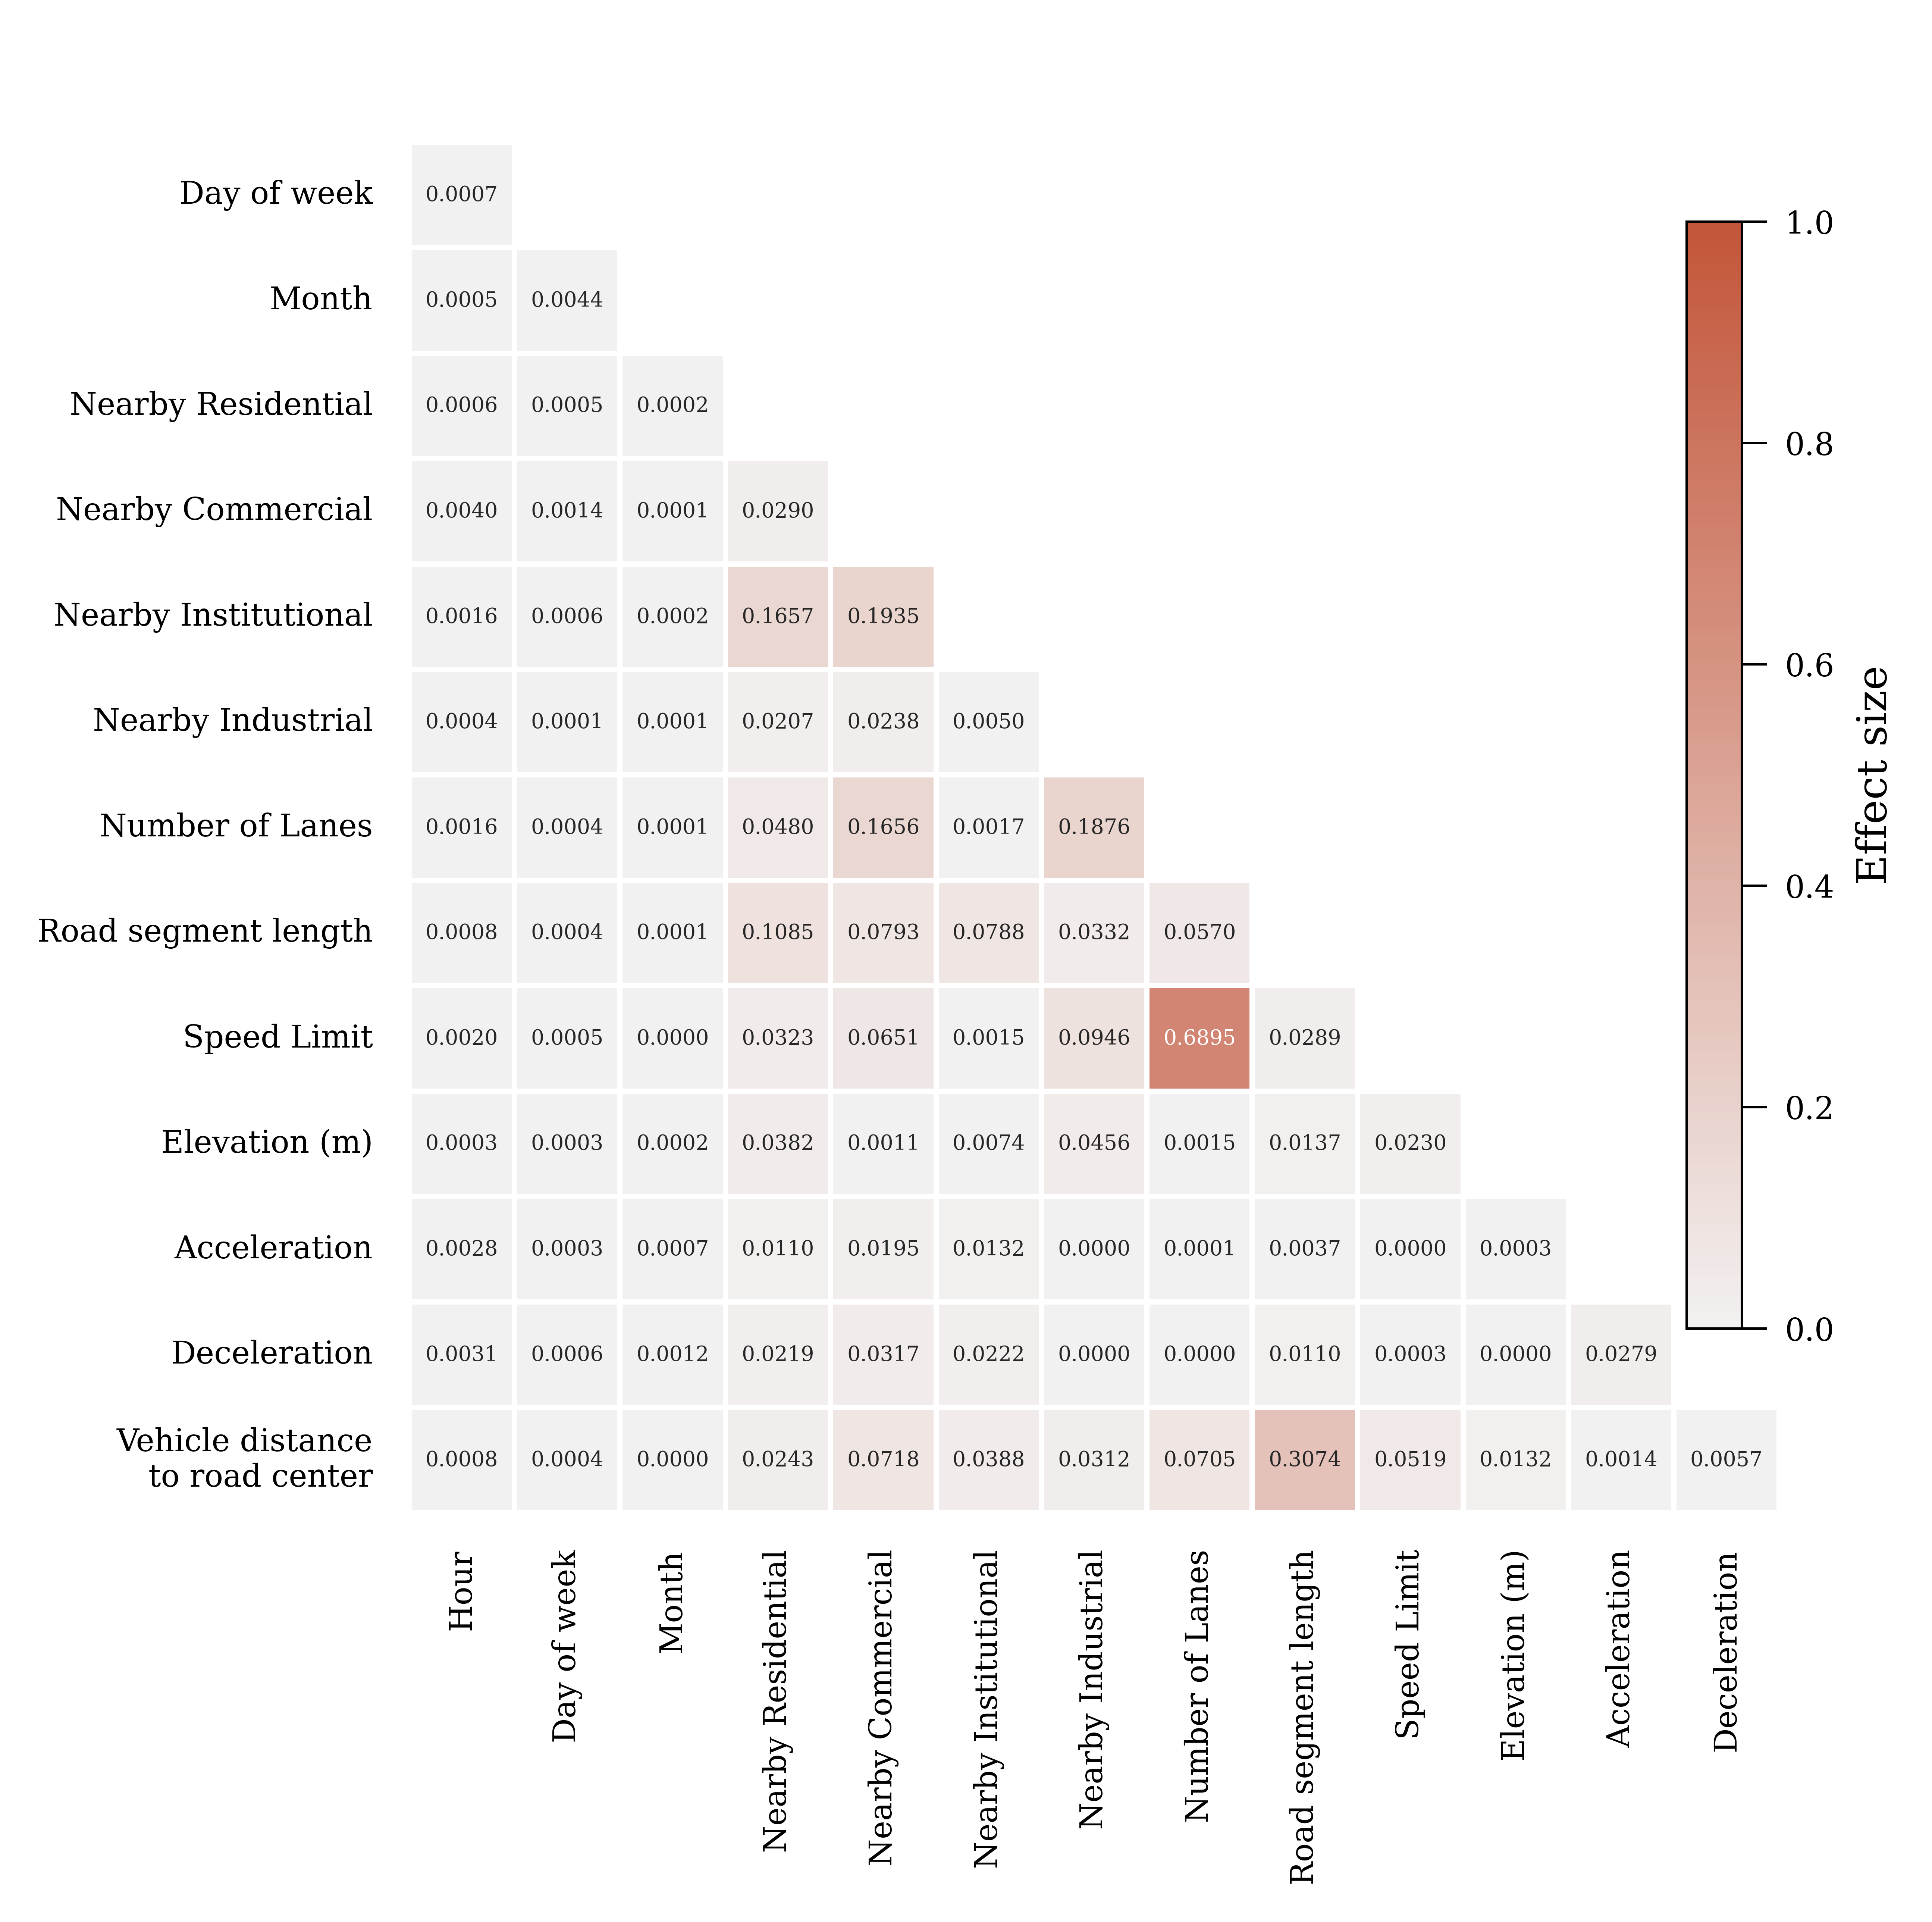

In [22]:
import seaborn as sns

# Generate a mask for the upper triangle
mask = np.triu(m=np.ones_like(adj_df, dtype=bool))

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(15, 15))
f, ax = plt.subplots(figsize=pu.figsizes['double'])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":15})   

ax.tick_params(axis='both', left=False, bottom=False, labelsize=pu.tiny)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(adj_df, 
            mask=mask, 
            cmap=cmap, 
            annot=True, fmt='.4f', annot_kws={"size": 4},
            vmax=1.0, vmin=0.0, center=0,
            square=True, 
            linewidths=1.0, 
            cbar_kws={
                "shrink": 0.75, 'label':'Effect size', 'pad' : -0.1,
            },
            ax=ax)

xlabels = ax.get_xticklabels()
ylabels = ax.get_yticklabels()
xlabels[-1] = ylabels[0] = "" # remove 1st and last labels

ax.set_yticklabels(ylabels)
ax.set_xticklabels(xlabels)

ax.collections[0].colorbar.outline.set_color("black")
ax.collections[0].colorbar.outline.set_linewidth(0.5)
ax.collections[0].colorbar.ax.tick_params(labelsize=pu.tiny, width=0.5)
cbar_ylabel = ax.collections[0].colorbar.ax.get_ylabel()
ax.collections[0].colorbar.ax.set_ylabel(cbar_ylabel, fontsize=pu.label_size)

# ax.set_title('Effect Size Heatmap of Features', fontsize=20)

plt.savefig('../figures/effect_size_heatmap_FULL.pdf', bbox_inches='tight')
# plt.savefig('../figures/effect_size_heatmap_FILTERED.pdf', bbox_inches='tight')
plt.show()

## End